# Smartphone and MCU-board data sync

This document provides an example of two independent system time sync:
1. Smartphone with built-in IMU
2. MCU-board with connected IMU

It is assumed that IMU measurements are perfectly timestamped for both devices. This fact is verified for this devices. More information can be found in the [paper](https://www.mdpi.com/1424-8220/21/1/68).

The task is to find time offset between this two devices

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import twistnsync as tns

### Obtain data

In [2]:
sm_gyro_df = pd.read_csv('data/smartphone_and_mcu_gyro_data/smartphone_gyro_data.csv')
mcu_gyro_df = pd.read_csv('data/smartphone_and_mcu_gyro_data/mcu_gyro_data.csv')

In [3]:
sm_gyro_time = sm_gyro_df[['sm_time']].to_numpy().squeeze()
sm_gyro_data = sm_gyro_df[['sm_x', 'sm_y', 'sm_z']].to_numpy()

mcu_gyro_time = mcu_gyro_df[['mcu_time']].to_numpy().squeeze()
mcu_gyro_data = mcu_gyro_df[['mcu_x', 'mcu_y', 'mcu_z']].to_numpy()

In [4]:
d = np.array([1.0, 0.0, -1.0])

sm_color = 'b'
mcu_color = 'purple'

### Smartphone and MCU-board MEMS-gyroscope data
This plot shows data samples for Smartphone and MCU-board MEMS-gyroscope data  
Notice that $X$-axis is not time but sample number

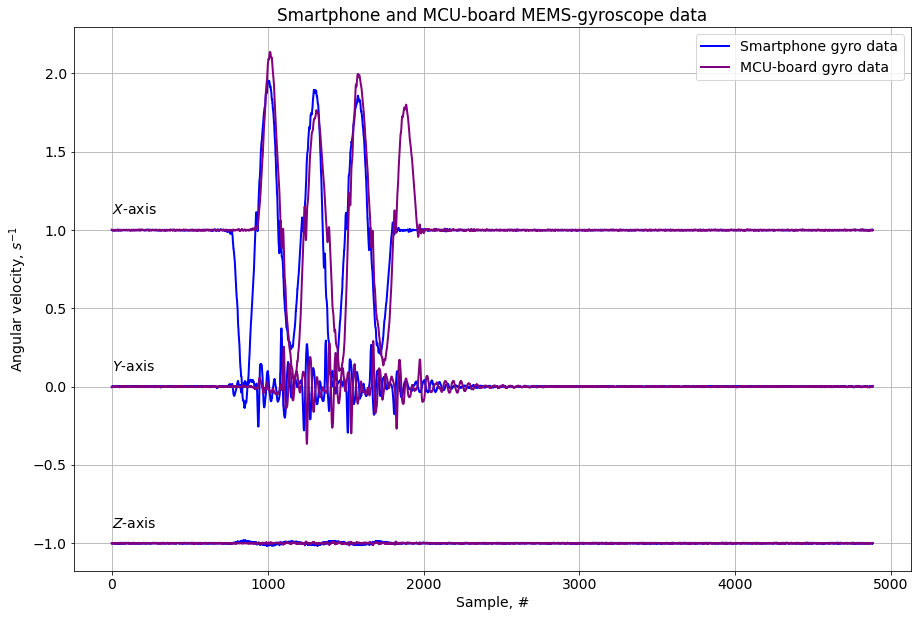

In [5]:
plt.figure(figsize=(15,10))

sm_lines = plt.plot(sm_gyro_data + d, c=sm_color, linewidth=2)
mcu_lines = plt.plot(mcu_gyro_data + d, c=mcu_color, linewidth=2)

plt.text(0, 1.1, r'$X$-axis'); plt.text(0, 0.1, r'$Y$-axis'); plt.text(0, -0.9, r'$Z$-axis')
plt.title('Smartphone and MCU-board MEMS-gyroscope data')
plt.xlabel(r'Sample, #')
plt.ylabel(r'Angular velocity, $s^{-1}$')
plt.grid()
plt.legend([sm_lines[0], mcu_lines[0]], ['Smartphone gyro data', 'MCU-board gyro data']);

### Smartphone and MCU-board MEMS-gyroscope data assuming common time domain
This plot shows the same data but under the assumption that `sm_gyro_time` and `mcu_gyro_time` belong to a common time domain (which is __not__ true since Smartphone and MCU clocks are independent and not synchronized).

The result shows that there is more than 800000 seconds offfset between the clocks.

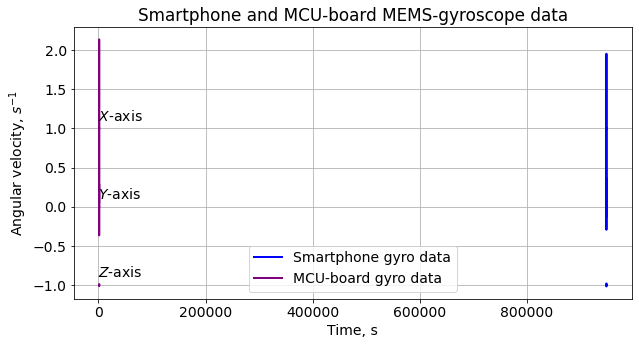

In [6]:
plt.figure(figsize=(10,5))

sm_lines = plt.plot(sm_gyro_time, sm_gyro_data + d, c=sm_color, linewidth=2)
mcu_lines = plt.plot(mcu_gyro_time, mcu_gyro_data + d, c=mcu_color, linewidth=2)

plt.text(0, 1.1, r'$X$-axis'); plt.text(0, 0.1, r'$Y$-axis'); plt.text(0, -0.9, r'$Z$-axis')
plt.title('Smartphone and MCU-board MEMS-gyroscope data')
plt.xlabel(r'Time, s')
plt.ylabel(r'Angular velocity, $s^{-1}$')
plt.grid()
plt.legend([sm_lines[0], mcu_lines[0]], ['Smartphone gyro data', 'MCU-board gyro data']);

### Time sync process by `twistnsync` module
It is a good practice to remove gyroscope bias to provide close-to-zero measurements in the beginnig and end of data sets. Skipping this step usually leads to worse performance of data sync.  

__Step 0/3.__ Remove gyroscope bias by subtracting mean data of a __steady__ state  
In this example we assume that steady, moveless state was from starting point up to 500th sample number for both smartphone and MCU-board gyro data sets. For instance, subset from 0 to 1000 sample numbers is not valid since it is already captures motions.

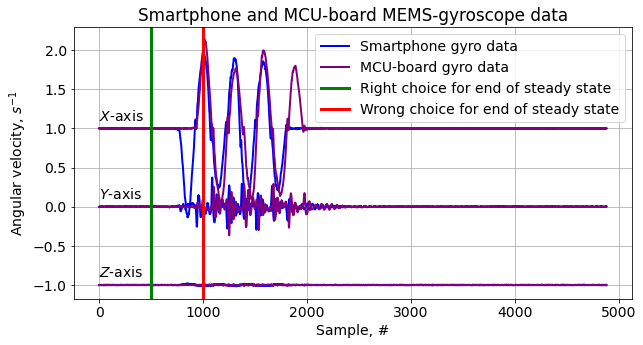

In [7]:
plt.figure(figsize=(10,5))

sm_lines = plt.plot(sm_gyro_data + d, c=sm_color, linewidth=2)
mcu_lines = plt.plot(mcu_gyro_data + d, c=mcu_color, linewidth=2)

right_sample_number = 500
right_choice = plt.axvline(right_sample_number, c='g', linewidth=3)

wrong_sample_number = 1000
wrong_choice = plt.axvline(wrong_sample_number, c='r', linewidth=3)

plt.text(0, 1.1, r'$X$-axis'); plt.text(0, 0.1, r'$Y$-axis'); plt.text(0, -0.9, r'$Z$-axis')
plt.title('Smartphone and MCU-board MEMS-gyroscope data')
plt.xlabel(r'Sample, #')
plt.ylabel(r'Angular velocity, $s^{-1}$')
plt.grid()
plt.legend(
    [sm_lines[0], mcu_lines[0], 
     right_choice, wrong_choice], 
    ['Smartphone gyro data', 'MCU-board gyro data', 
     'Right choice for end of steady state', 'Wrong choice for end of steady state']);

In [8]:
sm_bias = sm_gyro_data[:right_sample_number].mean(axis=0)
mcu_bias = mcu_gyro_data[:right_sample_number].mean(axis=0)

print('Smartphone gyro bias:', sm_bias)
print('MCU-board gyro bias:', mcu_bias)

sm_gyro_data_unbiased = sm_gyro_data - sm_bias
mcu_gyro_data_unbiased = mcu_gyro_data - mcu_bias

Smartphone gyro bias: [-7.26929724e-05  5.49778581e-05  4.88693192e-06]
MCU-board gyro bias: [-5.00949465e-05 -2.47810108e-05  1.85724349e-04]


__Step 1/3.__ Define `time_sync` object. Provide unbiased data. Notice the order.

Later biased data are utilized for visualization.

In [9]:
time_sync = tns.TimeSync(
    sm_gyro_data_unbiased,  # Unbiased smartphone gyro samples
    mcu_gyro_data_unbiased, # Unbiased MCU-board gyro samples
    sm_gyro_time,           # Smartphone gyro timestamps
    mcu_gyro_time           # MCU-board gyro timestamps
)

__Step 2/3.__ Make data resample to provide equvi-distant measurements important for the algorithm. 


If `step=None`, resampling step size will be automatically chosen as the shortest mean sampling period from given data. In this example, every data set obtained with 500 Hz sampling rate or 2 ms sampling period; thus step size is of 0.002 will be chosen. 

If, for instance, sampling period of the first dataset is 1 ms and 2 ms for the second one, 0.001 will be chosen.

Exact value can be chosen by `step=value`.

In [10]:
time_sync.resample(step=None)

__Step 3/3.__ Obtain time offset

In [11]:
time_sync.obtain_delay()

computed_offset = time_sync.time_delay

In [12]:
time_offset = sm_gyro_time[0] - mcu_gyro_time[0] - computed_offset
print('Time offset between smartphone and MCU clocks is', time_offset, 's')

Time offset between smartphone and MCU clocks is 947848.6384083075 s


### Plot synchronized gyro data

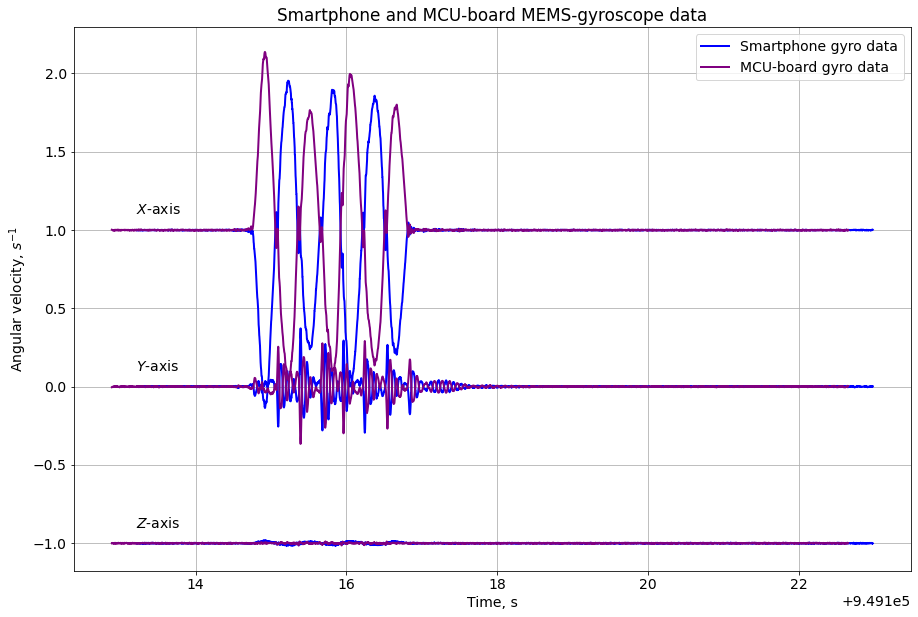

In [13]:
plt.figure(figsize=(15,10))


sm_lines = plt.plot(sm_gyro_time, sm_gyro_data + d, c=sm_color, linewidth=2)
mcu_lines = plt.plot(mcu_gyro_time + time_offset, mcu_gyro_data + d, c=mcu_color, linewidth=2)

plt.text(sm_gyro_time[0],  1.1, r'$X$-axis')
plt.text(sm_gyro_time[0],  0.1, r'$Y$-axis')
plt.text(sm_gyro_time[0], -0.9, r'$Z$-axis')
plt.title('Smartphone and MCU-board MEMS-gyroscope data')
plt.xlabel(r'Time, s')
plt.ylabel(r'Angular velocity, $s^{-1}$')
plt.grid()
plt.legend([sm_lines[0], mcu_lines[0]], ['Smartphone gyro data', 'MCU-board gyro data']);

### Extra. Plot synchronized and aligned gyro data

During data sync, _relative_ calibration of gyroscopes is performed and calibration/transformation matrix `M` is computed as a secondary result of the algorithm. This matrix may be useful to align data not only in time but also in geometry.

The plot below utilize `M` to align gyro data.

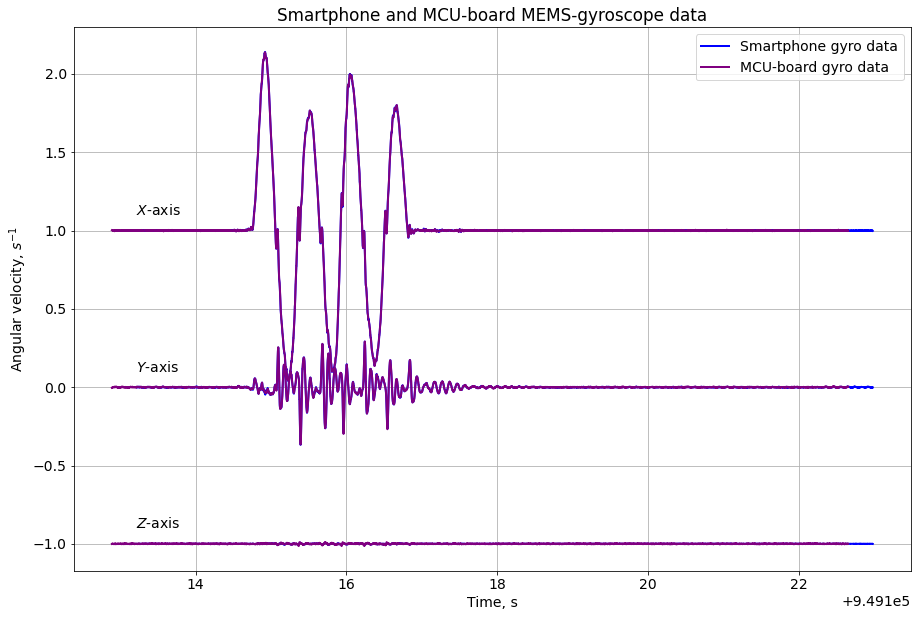

In [14]:
plt.figure(figsize=(15,10))


sm_gyro_data_aligned = (time_sync.M@sm_gyro_data.T).T

sm_lines = plt.plot(sm_gyro_time, sm_gyro_data_aligned + d, c=sm_color, linewidth=2)
mcu_lines = plt.plot(mcu_gyro_time  + time_offset, mcu_gyro_data + d, c=mcu_color, linewidth=2)

plt.text(sm_gyro_time[0],  1.1, r'$X$-axis')
plt.text(sm_gyro_time[0],  0.1, r'$Y$-axis')
plt.text(sm_gyro_time[0], -0.9, r'$Z$-axis')
plt.title('Smartphone and MCU-board MEMS-gyroscope data')
plt.xlabel(r'Time, s')
plt.ylabel(r'Angular velocity, $s^{-1}$')
plt.grid()
plt.legend([sm_lines[0], mcu_lines[0]], ['Smartphone gyro data', 'MCU-board gyro data']);